# Softmax and Momentum
### Implemented a softmax classifier using using stochastic gradient descent with mini-batches and momentum to minimize softmax (cross-entropy) loss with L2 weight decay regularization of this single layer neural network
![title](softmax.png)

## Import libraries

In [14]:
import numpy as np
import random, argparse
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

## NeuralNetwork implementation

### Here i implemented class that contains such parameters like:
* epochs: Number of iterations over complete training data
* learningRate: A step size or a learning rate
* batchSize: A mini-batch size(less than total number of training data)
* regStrength: A regularization strength
* momentum: A momentum value
### And functions:

```

```
* train
```
        Train a softmax classifier model on training data using stochastic gradient descent with mini-batches
        and momentum to minimize softmax (cross-entropy) loss of this single layer neural network. It calcualtes
        mean per-class accuracy for the training/testing data and the loss.
        xTrain: Training input data
        yTrain: Training labels
        xTest: Testing input data
        yTest: Testing labels
        return: A tuple of training/Testing losses and Accuracy
```
* SGDWithMomentum
```
        Stochastic gradient descent with mini-batches. It divides training data into mini-batches
        and compute loss and grad on that mini-batches and updates the weights. It repeats for all samples.
        x: An input samples
        y: An input labels
        return: Total loss computed
```
* softmaxEquation
```
        It calculates a softmax probability
        z: A matrix(wt * input sample)
        return: softmax probability
```
* computeLoss
```
        It calculates a cross-entropy loss with regularization loss and gradient to update the weights.
        x: An input sample
        yMatrix: Label as one-hot encoding
```
* meanAccuracy
```
        It calculates mean-per class accuracy
        x: Input sample
        y: label sample
        return: mean-per class accuracy
```
* predict
```
        It predict the label based on input sample and a model
        x: Input sample
        return: predicted label
```
* oneHotEncoding
```
        Convert a vector into one-hot encoding matrix where that particular column value is 1 and rest 0 for that row.
        y: Label vector
        numOfClasses: Number of unique labels
        return: one-hot encoding matrix
```
### Data operations:

```

```
* plotGraph
```
    Plot a Epochs vs. Cross Entropy Loss graph
    trainLosses: List of training loss over every epochs
    testLosses: List of testing loss over every epochs
    trainAcc: List of training accuracy over every epochs
    testAcc: List of testing accuracy over every epochs
```
* readData
```
    Read data from file and divide into input sample and a label.
    filename: name of a file
    input sample and label
```
* makeMeshGrid
```
    Create a mesh point to plot decision boundary.
    x: data or sample (for x-axis on meshgrid)
    y: label(for y-axis on meshgrid)
    h: step size for meshgrid
    return: matrix of x-axis and y-axis
```
* plotContours
```
    It plot a contour.
    plt: A matplotlib.pyplot object
    model: softmax classifier model
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: Number of parameters to pass to contour function
```

In [39]:
class Softmax:

    def __init__(self, epochs, learningRate, batchSize, regStrength, momentum):
        self.epochs = epochs
        self.learningRate = learningRate
        self.batchSize = batchSize
        self.regStrength = regStrength
        self.momentum = momentum
        self.velocity = None
        self.wt = None

    def train(self, xTrain, yTrain, xTest, yTest):
        D = xTrain.shape[1]  # dimensionality
        label = np.unique(yTrain)
        numOfClasses = len(label) # number of classes
        yTrainEnc = self.oneHotEncoding(yTrain, numOfClasses)
        yTestEnc = self.oneHotEncoding(yTest, numOfClasses)
        self.wt = 0.001 * np.random.rand(D, numOfClasses)
        self.velocity = np.zeros(self.wt.shape)
        trainLosses = []
        testLosses = []
        trainAcc = []
        testAcc = []
        for e in range(self.epochs): # loop over epochs
            trainLoss = self.SGDWithMomentum(xTrain, yTrainEnc)
            testLoss, dw = self.computeLoss(xTest, yTestEnc)
            trainAcc.append(self.meanAccuracy(xTrain, yTrain))
            testAcc.append(self.meanAccuracy(xTest, yTest))
            trainLosses.append(trainLoss)
            testLosses.append(testLoss)
            print("{:d}->TrainL : {:.7f}|\tTestL : {:.7f}|\tTrainAcc : {:.7f}|TestAcc: {:.7f}"
                  .format(e, trainLoss, testLoss, trainAcc[-1], testAcc[-1]))
        return trainLosses, testLosses, trainAcc, testAcc

    def SGDWithMomentum(self, x, y):
        losses = []
        randomIndices = random.sample(range(x.shape[0]), x.shape[0])
        x = x[randomIndices]
        y = y[randomIndices]
        for i in range(0, x.shape[0], self.batchSize):
            Xbatch = x[i:i+self.batchSize]
            ybatch = y[i:i+self.batchSize]
            loss, dw = self.computeLoss(Xbatch, ybatch)
            self.velocity = (self.momentum * self.velocity) + (self.learningRate * dw)
            self.wt -= self.velocity
            losses.append(loss)
        return np.sum(losses) / len(losses)

    def softmaxEquation(self, z):
        z -= np.max(z)
        prob = (np.exp(z).T / np.sum(np.exp(z), axis=1)).T
        return prob

    def computeLoss(self, x, yMatrix):
        numOfSamples = x.shape[0]
        scores = np.dot(x, self.wt)
        prob = self.softmaxEquation(scores)

        loss = -np.log(np.max(prob)) * yMatrix
        regLoss = (1/2)*self.regStrength*np.sum(self.wt*self.wt)
        totalLoss = (np.sum(loss) / numOfSamples) + regLoss
        grad = ((-1 / numOfSamples) * np.dot(x.T, (yMatrix - prob))) + (self.regStrength * self.wt)
        return totalLoss, grad

    def meanAccuracy(self, x, y):
        predY = self.predict(x)
        predY = predY.reshape((-1, 1))  # convert to column vector
        return np.mean(np.equal(y, predY))

    def predict(self, x):
        return np.argmax(x.dot(self.wt), 1)

    def oneHotEncoding(self, y, numOfClasses):
        y = np.asarray(y, dtype='int32')
        if len(y) > 1:
            y = y.reshape(-1)
        if not numOfClasses:
            numOfClasses = np.max(y) + 1
        yMatrix = np.zeros((len(y), numOfClasses))
        yMatrix[np.arange(len(y)), y] = 1
        return yMatrix


def plotGraph(trainLosses, testLosses, trainAcc, testAcc):
    plt.figure(figsize=(16,6))
    plt.subplot(1, 2, 1)
    plt.plot(trainLosses, label="Train loss")
    plt.plot(testLosses, label="Test loss")
    plt.legend(loc='best')
    plt.title("Epochs vs. Cross Entropy Loss")
    plt.xlabel("Number of Iteration or Epochs")
    plt.ylabel("Cross Entropy Loss")

    plt.subplot(1, 2, 2)
    plt.plot(trainAcc, label="Train Accuracy")
    plt.plot(testAcc, label="Test Accuracy")
    plt.legend(loc='best')
    plt.title("Epochs vs. Mean per class Accuracy")
    plt.xlabel("Number of Iteration or Epochs")
    plt.ylabel("Mean per class Accuracy")
    plt.show()

def readData(filename):
    dataMatrix = np.loadtxt(filename)
    np.random.shuffle(dataMatrix)
    X = dataMatrix[:, 1:]
    y = dataMatrix[:, 0].astype(int)
    y = y.reshape((-1, 1))
    y -= 1
    return X, y

def makeMeshGrid(x, y, h=0.02):
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plotContours(plt, model, xx, yy, **params):
    arr = np.array([xx.ravel(), yy.ravel()])
    scores = np.dot(arr.T, sm.wt)
    prob = model.softmaxEquation(scores)
    Z = np.argmax(prob, axis=1) + 1

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, **params)

def plotDecisionBoundary(x, y):
    plt.figure(figsize=(16,7))
    markers = ('+', '.', 'x')
    colors = ('#8B0000', '#000000', '#191970')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    xx, yy = makeMeshGrid(x, y)
    plotContours(plt, sm, xx, yy, cmap=plt.cm.viridis, alpha=0.8)
    # Plot also the training points
    for idx, cl in enumerate(np.unique(y)):
        xBasedOnLabel = x[np.where(y[:,0] == cl)]
        plt.scatter(x=xBasedOnLabel[:, 0], y=xBasedOnLabel[:, 1], c=cmap(idx),
                    cmap=plt.cm.coolwarm, marker=markers[idx], label=cl)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel("Feature X1")
    plt.ylabel("Feature X2")
    plt.title("Softmax Classifier on Iris Dataset(Decision Boundary)")
    plt.xticks()
    plt.yticks()
    plt.legend(loc='upper left')
    plt.show()



Epochs: 1000 | Learning Rate: 0.07 | Batch Size: 10 | Regularization Strength: 0.001 | Momentum: 0.05 |
0->TrainL : 1.0842616|	TestL : 1.0715114|	TrainAcc : 0.3333333|TestAcc: 0.3137255
1->TrainL : 1.0625069|	TestL : 1.0480144|	TrainAcc : 0.3333333|TestAcc: 0.3137255
2->TrainL : 1.0392679|	TestL : 1.0283703|	TrainAcc : 0.3333333|TestAcc: 0.3137255
3->TrainL : 1.0133120|	TestL : 1.0128666|	TrainAcc : 0.3333333|TestAcc: 0.3137255
4->TrainL : 1.0053877|	TestL : 0.9986417|	TrainAcc : 0.3333333|TestAcc: 0.3137255
5->TrainL : 0.9974975|	TestL : 0.9842827|	TrainAcc : 0.3444444|TestAcc: 0.3137255
6->TrainL : 0.9765235|	TestL : 0.9734818|	TrainAcc : 0.3444444|TestAcc: 0.3333333
7->TrainL : 0.9717732|	TestL : 0.9628238|	TrainAcc : 0.3555556|TestAcc: 0.3333333
8->TrainL : 0.9568165|	TestL : 0.9536349|	TrainAcc : 0.3555556|TestAcc: 0.3333333
9->TrainL : 0.9724412|	TestL : 0.9406619|	TrainAcc : 0.4222222|TestAcc: 0.3725490
10->TrainL : 0.9462835|	TestL : 0.9329780|	TrainAcc : 0.4222222|TestAcc: 0.3

201->TrainL : 0.3734005|	TestL : 0.2370976|	TrainAcc : 0.7777778|TestAcc: 0.8235294
202->TrainL : 0.3204598|	TestL : 0.2360347|	TrainAcc : 0.7555556|TestAcc: 0.8235294
203->TrainL : 0.3618689|	TestL : 0.2353526|	TrainAcc : 0.7555556|TestAcc: 0.8235294
204->TrainL : 0.3468601|	TestL : 0.2341177|	TrainAcc : 0.7666667|TestAcc: 0.8235294
205->TrainL : 0.3412822|	TestL : 0.2329426|	TrainAcc : 0.7777778|TestAcc: 0.8431373
206->TrainL : 0.3285121|	TestL : 0.2317771|	TrainAcc : 0.7777778|TestAcc: 0.8431373
207->TrainL : 0.4081942|	TestL : 0.2307318|	TrainAcc : 0.7777778|TestAcc: 0.8431373
208->TrainL : 0.3473240|	TestL : 0.2290013|	TrainAcc : 0.7666667|TestAcc: 0.8431373
209->TrainL : 0.3151966|	TestL : 0.2278904|	TrainAcc : 0.7666667|TestAcc: 0.8431373
210->TrainL : 0.3378400|	TestL : 0.2266125|	TrainAcc : 0.7666667|TestAcc: 0.8431373
211->TrainL : 0.3290837|	TestL : 0.2254561|	TrainAcc : 0.7666667|TestAcc: 0.8431373
212->TrainL : 0.3316461|	TestL : 0.2243065|	TrainAcc : 0.7777778|TestAcc: 0.

299->TrainL : 0.2801003|	TestL : 0.1567270|	TrainAcc : 0.7777778|TestAcc: 0.8235294
300->TrainL : 0.2745628|	TestL : 0.1563681|	TrainAcc : 0.7777778|TestAcc: 0.8235294
301->TrainL : 0.2525538|	TestL : 0.1558459|	TrainAcc : 0.7777778|TestAcc: 0.8235294
302->TrainL : 0.2773534|	TestL : 0.1549837|	TrainAcc : 0.7777778|TestAcc: 0.8039216
303->TrainL : 0.2583400|	TestL : 0.1545720|	TrainAcc : 0.7777778|TestAcc: 0.8235294
304->TrainL : 0.2390961|	TestL : 0.1541315|	TrainAcc : 0.7777778|TestAcc: 0.8235294
305->TrainL : 0.2585418|	TestL : 0.1535530|	TrainAcc : 0.7777778|TestAcc: 0.8235294
306->TrainL : 0.2204757|	TestL : 0.1531166|	TrainAcc : 0.7777778|TestAcc: 0.8235294
307->TrainL : 0.2764271|	TestL : 0.1527399|	TrainAcc : 0.7777778|TestAcc: 0.8235294
308->TrainL : 0.2420154|	TestL : 0.1521512|	TrainAcc : 0.7777778|TestAcc: 0.8235294
309->TrainL : 0.2815602|	TestL : 0.1517030|	TrainAcc : 0.7777778|TestAcc: 0.8235294
310->TrainL : 0.2707480|	TestL : 0.1510120|	TrainAcc : 0.7777778|TestAcc: 0.

400->TrainL : 0.2095548|	TestL : 0.1161473|	TrainAcc : 0.7888889|TestAcc: 0.8235294
401->TrainL : 0.3106887|	TestL : 0.1157960|	TrainAcc : 0.7777778|TestAcc: 0.8235294
402->TrainL : 0.1853243|	TestL : 0.1156309|	TrainAcc : 0.7888889|TestAcc: 0.8235294
403->TrainL : 0.2320649|	TestL : 0.1154236|	TrainAcc : 0.7777778|TestAcc: 0.8235294
404->TrainL : 0.2064151|	TestL : 0.1151014|	TrainAcc : 0.7888889|TestAcc: 0.8235294
405->TrainL : 0.2049159|	TestL : 0.1149217|	TrainAcc : 0.7888889|TestAcc: 0.8235294
406->TrainL : 0.2191674|	TestL : 0.1146950|	TrainAcc : 0.7888889|TestAcc: 0.8235294
407->TrainL : 0.2293178|	TestL : 0.1142507|	TrainAcc : 0.7777778|TestAcc: 0.8235294
408->TrainL : 0.2198666|	TestL : 0.1139016|	TrainAcc : 0.7777778|TestAcc: 0.8235294
409->TrainL : 0.2023837|	TestL : 0.1134520|	TrainAcc : 0.7777778|TestAcc: 0.8235294
410->TrainL : 0.2748731|	TestL : 0.1130402|	TrainAcc : 0.7777778|TestAcc: 0.8235294
411->TrainL : 0.1746064|	TestL : 0.1128235|	TrainAcc : 0.7777778|TestAcc: 0.

512->TrainL : 0.1803942|	TestL : 0.0915069|	TrainAcc : 0.8000000|TestAcc: 0.8235294
513->TrainL : 0.1824948|	TestL : 0.0913123|	TrainAcc : 0.7888889|TestAcc: 0.8235294
514->TrainL : 0.1823393|	TestL : 0.0912743|	TrainAcc : 0.8000000|TestAcc: 0.8235294
515->TrainL : 0.2193690|	TestL : 0.0912561|	TrainAcc : 0.8111111|TestAcc: 0.8235294
516->TrainL : 0.1928306|	TestL : 0.0910282|	TrainAcc : 0.8000000|TestAcc: 0.8235294
517->TrainL : 0.1738931|	TestL : 0.0909689|	TrainAcc : 0.8111111|TestAcc: 0.8235294
518->TrainL : 0.2252479|	TestL : 0.0907568|	TrainAcc : 0.8111111|TestAcc: 0.8235294
519->TrainL : 0.1884275|	TestL : 0.0905498|	TrainAcc : 0.8000000|TestAcc: 0.8235294
520->TrainL : 0.1743967|	TestL : 0.0904788|	TrainAcc : 0.8111111|TestAcc: 0.8235294
521->TrainL : 0.1389245|	TestL : 0.0902584|	TrainAcc : 0.8000000|TestAcc: 0.8235294
522->TrainL : 0.2101960|	TestL : 0.0900950|	TrainAcc : 0.8000000|TestAcc: 0.8235294
523->TrainL : 0.2145408|	TestL : 0.0900044|	TrainAcc : 0.8111111|TestAcc: 0.

620->TrainL : 0.1856182|	TestL : 0.0777640|	TrainAcc : 0.8000000|TestAcc: 0.8235294
621->TrainL : 0.1774281|	TestL : 0.0776290|	TrainAcc : 0.8111111|TestAcc: 0.8235294
622->TrainL : 0.1606768|	TestL : 0.0774637|	TrainAcc : 0.8111111|TestAcc: 0.8431373
623->TrainL : 0.1412023|	TestL : 0.0773746|	TrainAcc : 0.8111111|TestAcc: 0.8431373
624->TrainL : 0.1330539|	TestL : 0.0772766|	TrainAcc : 0.8111111|TestAcc: 0.8431373
625->TrainL : 0.1846146|	TestL : 0.0771599|	TrainAcc : 0.8111111|TestAcc: 0.8431373
626->TrainL : 0.1461064|	TestL : 0.0770699|	TrainAcc : 0.8111111|TestAcc: 0.8431373
627->TrainL : 0.1432371|	TestL : 0.0770187|	TrainAcc : 0.8111111|TestAcc: 0.8235294
628->TrainL : 0.1811725|	TestL : 0.0769368|	TrainAcc : 0.8000000|TestAcc: 0.8235294
629->TrainL : 0.1964168|	TestL : 0.0768161|	TrainAcc : 0.8111111|TestAcc: 0.8235294
630->TrainL : 0.1252326|	TestL : 0.0766510|	TrainAcc : 0.8111111|TestAcc: 0.8431373
631->TrainL : 0.1574513|	TestL : 0.0766677|	TrainAcc : 0.8000000|TestAcc: 0.

723->TrainL : 0.1411671|	TestL : 0.0687710|	TrainAcc : 0.8000000|TestAcc: 0.8235294
724->TrainL : 0.1607164|	TestL : 0.0687438|	TrainAcc : 0.8000000|TestAcc: 0.8235294
725->TrainL : 0.1625743|	TestL : 0.0686039|	TrainAcc : 0.8111111|TestAcc: 0.8431373
726->TrainL : 0.1738658|	TestL : 0.0685714|	TrainAcc : 0.8000000|TestAcc: 0.8235294
727->TrainL : 0.1665668|	TestL : 0.0686262|	TrainAcc : 0.8000000|TestAcc: 0.8235294
728->TrainL : 0.1173431|	TestL : 0.0685708|	TrainAcc : 0.8000000|TestAcc: 0.8235294
729->TrainL : 0.1888014|	TestL : 0.0684914|	TrainAcc : 0.8000000|TestAcc: 0.8235294
730->TrainL : 0.1364749|	TestL : 0.0684201|	TrainAcc : 0.8000000|TestAcc: 0.8235294
731->TrainL : 0.1671468|	TestL : 0.0683184|	TrainAcc : 0.8000000|TestAcc: 0.8235294
732->TrainL : 0.1388804|	TestL : 0.0681986|	TrainAcc : 0.8000000|TestAcc: 0.8235294
733->TrainL : 0.1623751|	TestL : 0.0681792|	TrainAcc : 0.8000000|TestAcc: 0.8235294
734->TrainL : 0.1431653|	TestL : 0.0680689|	TrainAcc : 0.8000000|TestAcc: 0.

828->TrainL : 0.1045916|	TestL : 0.0623881|	TrainAcc : 0.8000000|TestAcc: 0.8235294
829->TrainL : 0.1233947|	TestL : 0.0623443|	TrainAcc : 0.8000000|TestAcc: 0.8235294
830->TrainL : 0.1284686|	TestL : 0.0622236|	TrainAcc : 0.8000000|TestAcc: 0.8235294
831->TrainL : 0.1515500|	TestL : 0.0621634|	TrainAcc : 0.8000000|TestAcc: 0.8235294
832->TrainL : 0.0962046|	TestL : 0.0620402|	TrainAcc : 0.8111111|TestAcc: 0.8235294
833->TrainL : 0.1719332|	TestL : 0.0621159|	TrainAcc : 0.8000000|TestAcc: 0.8235294
834->TrainL : 0.1651422|	TestL : 0.0622034|	TrainAcc : 0.8000000|TestAcc: 0.8235294
835->TrainL : 0.1365655|	TestL : 0.0621274|	TrainAcc : 0.8000000|TestAcc: 0.8235294
836->TrainL : 0.1473939|	TestL : 0.0620509|	TrainAcc : 0.8000000|TestAcc: 0.8235294
837->TrainL : 0.1318206|	TestL : 0.0620894|	TrainAcc : 0.8000000|TestAcc: 0.8235294
838->TrainL : 0.1403627|	TestL : 0.0620734|	TrainAcc : 0.8000000|TestAcc: 0.8235294
839->TrainL : 0.1344156|	TestL : 0.0620927|	TrainAcc : 0.8000000|TestAcc: 0.

934->TrainL : 0.1324196|	TestL : 0.0581062|	TrainAcc : 0.8111111|TestAcc: 0.8235294
935->TrainL : 0.1159170|	TestL : 0.0580877|	TrainAcc : 0.8111111|TestAcc: 0.8235294
936->TrainL : 0.1415572|	TestL : 0.0580861|	TrainAcc : 0.8111111|TestAcc: 0.8235294
937->TrainL : 0.1322185|	TestL : 0.0578493|	TrainAcc : 0.8000000|TestAcc: 0.8039216
938->TrainL : 0.1782763|	TestL : 0.0578382|	TrainAcc : 0.8000000|TestAcc: 0.8039216
939->TrainL : 0.1153064|	TestL : 0.0577756|	TrainAcc : 0.8000000|TestAcc: 0.8039216
940->TrainL : 0.1346774|	TestL : 0.0576872|	TrainAcc : 0.8000000|TestAcc: 0.8235294
941->TrainL : 0.1393210|	TestL : 0.0576677|	TrainAcc : 0.8000000|TestAcc: 0.8235294
942->TrainL : 0.1512841|	TestL : 0.0576326|	TrainAcc : 0.8000000|TestAcc: 0.8235294
943->TrainL : 0.1137141|	TestL : 0.0576041|	TrainAcc : 0.8000000|TestAcc: 0.8235294
944->TrainL : 0.1186582|	TestL : 0.0576147|	TrainAcc : 0.8000000|TestAcc: 0.8235294
945->TrainL : 0.1280784|	TestL : 0.0575726|	TrainAcc : 0.8000000|TestAcc: 0.

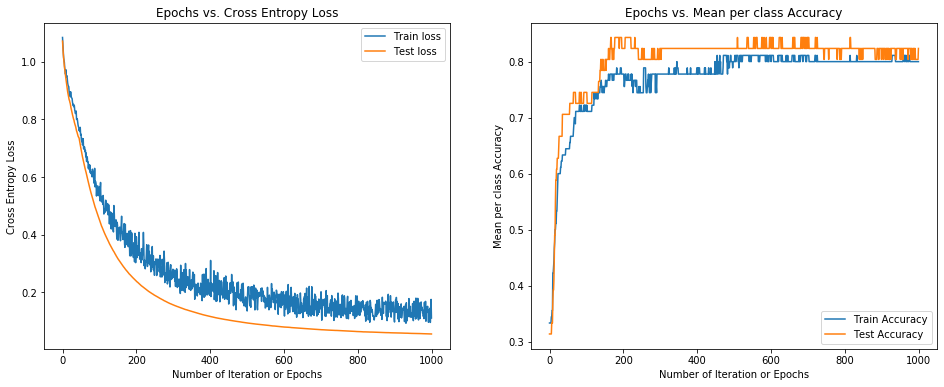

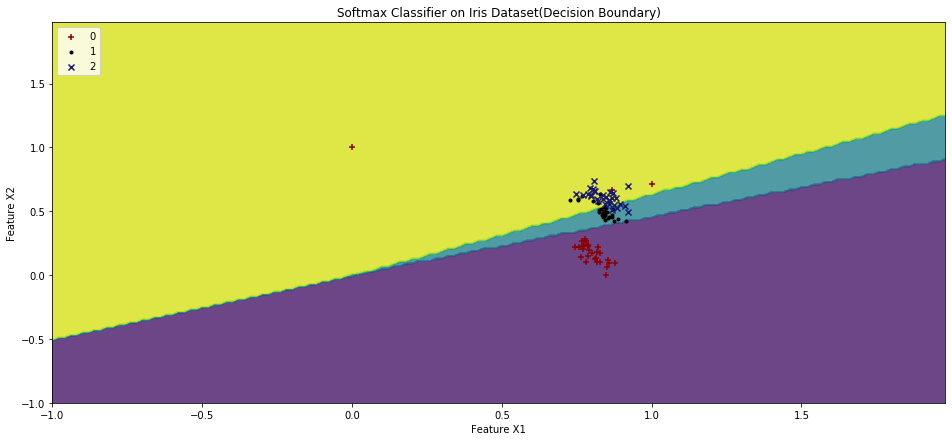

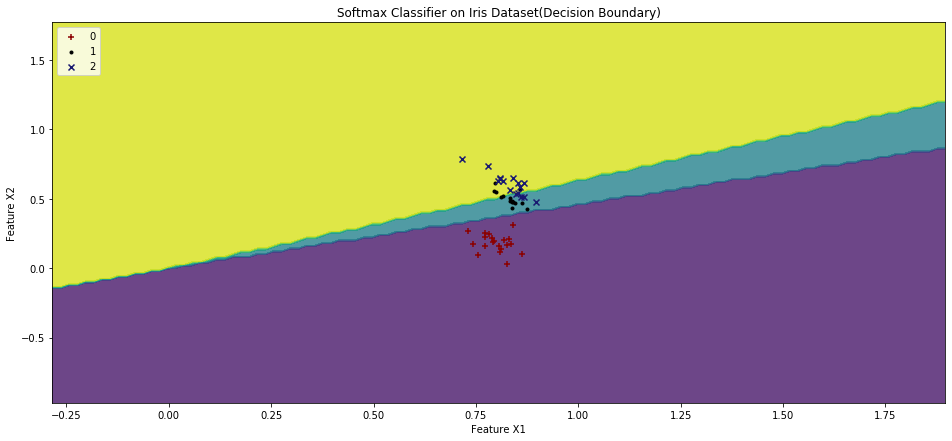

In [40]:
trainX, trainY = readData(TRAIN_FILENAME) # Training data
testX, testY = readData(TEST_FILENAME) # Testing data

parser = argparse.ArgumentParser()
parser.add_argument("-e", "--epochs", dest="epochs", default=1000,
                        type=int, help="Number of epochs")
parser.add_argument("-lr", "--learningrate", dest="learningRate", default=0.07,
                        type=float, help="Learning rate or step size")
parser.add_argument("-bs", "--batchSize", dest="batchSize", default=10,
                        type=int, help="Number of sample in mini-batches")
parser.add_argument("-r", "--regStrength", dest="regStrength", default=0.001,
                        type=float, help="L2 weight decay regularization lambda value")
parser.add_argument("-m", "--momentum", dest="momentum", default=0.05,
                        type=float, help="A momentum value")

args, unknown = parser.parse_known_args()

print(
        "Epochs: {} | Learning Rate: {} | Batch Size: {} | Regularization Strength: {} | "
        "Momentum: {} |".format(
            args.epochs,
            args.learningRate,
            args.batchSize,
            args.regStrength,
            args.momentum
        ))

epochs = int(args.epochs)
learningRate = float(args.learningRate)
batchSize = int(args.batchSize)
regStrength = int(args.regStrength)
momentum = int(args.momentum)


sm = Softmax(epochs=epochs, learningRate=learningRate, batchSize=batchSize,
                 regStrength=regStrength, momentum=momentum)
trainLosses, testLosses, trainAcc, testAcc = sm.train(trainX, trainY, testX, testY) # Train a network
plotGraph(trainLosses, testLosses, trainAcc, testAcc)
plotDecisionBoundary(trainX, trainY)
plotDecisionBoundary(testX, testY)